In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns

In [111]:
car_df = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv") #read in the csv file containing car information

First will we begin with some exploratory data analysis and data visualization, we will look at the structure of the data, whether there are missing values, whether the dataset is balanced ect. 

This will allow us to find any problems that we might encounter, and make informed decisions when doing our feature engineering and while building the eventual model that wil be implemented. 

First lets simply plot our target variable the car price, to see what the distribution of prices looks like. 

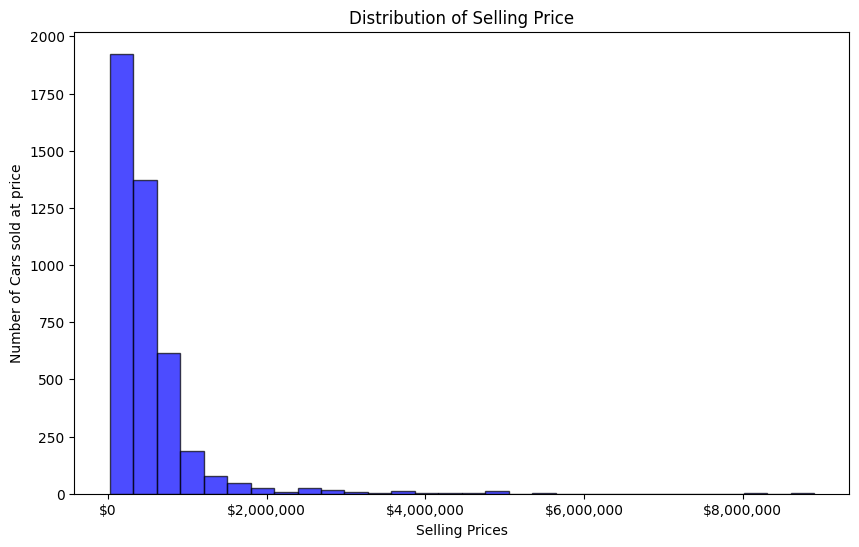

In [112]:
def format_ticks(x, pos):
    return f'${x:,.0f}'  # Formats numbers with thousands separator and dollar sign

plt.figure(figsize=(10, 6))
plt.hist(car_df['selling_price'], bins=30, color='blue', edgecolor='black', alpha=0.7)

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Distribution of Selling Price')
plt.xlabel('Selling Prices')
plt.ylabel('Number of Cars sold at price')
plt.show()

We see that we do have a very unbalanced data set, with a small number of outliers out in the price of the multiple million dollars. This makes sense, and it proabably repersentative of the market; however, for visualization purposes I will remove these outliers and than redisplay the data so that a more detailed look at the general distribution can be done. To determine outliers, I will use the standard metric of Q3 + 1.5 * IQR.

In [113]:
median = car_df['selling_price'].median()
q1 = car_df['selling_price'].quantile(0.25)  # 25th percentile (Q1)
q3 = car_df['selling_price'].quantile(0.75) 

outlier_bound = q3 + (1.5* (q3-q1))

outlier_excluded_df = car_df[car_df['selling_price'] < outlier_bound]

outlier_bound = round(outlier_bound, 2)

print(f"median: {median}, q1: {q1}, q3: {q3}. This means to be an outlier the price would be above ${outlier_bound}")

median: 350000.0, q1: 208749.75, q3: 600000.0. This means to be an outlier the price would be above $1186875.38


Above we created a dataset with the outliers excluded. We assumed based on the structure we only wanted to remove outliers from the top, since outliers below would be at a negative price. Below we will plot the new data also in a histogram to better visualize the strucutre. 

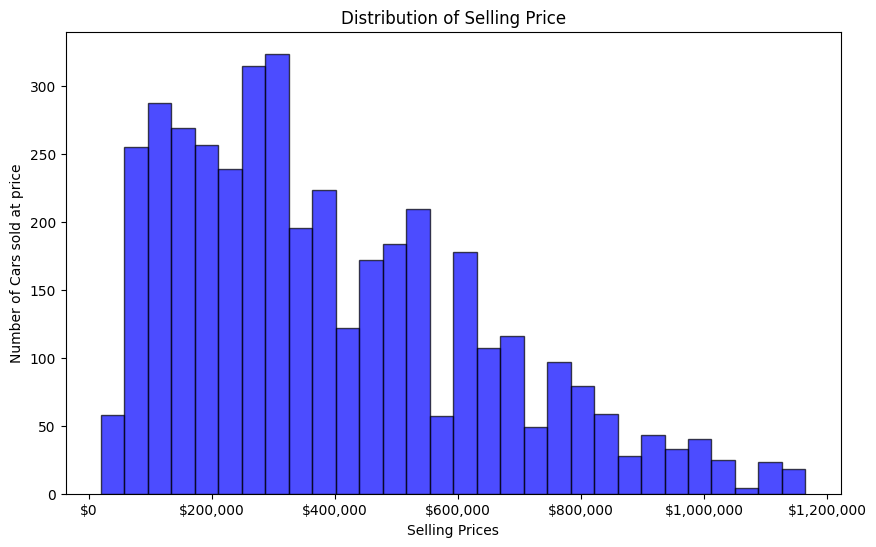

In [114]:
plt.figure(figsize=(10, 6))
plt.hist(outlier_excluded_df['selling_price'], bins=30, color='blue', edgecolor='black', alpha=0.7)

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Distribution of Selling Price')
plt.xlabel('Selling Prices')
plt.ylabel('Number of Cars sold at price')
plt.show()

Next we will conduct a correlation analysis. We want to see what the relationship between the different features in the dataset are.

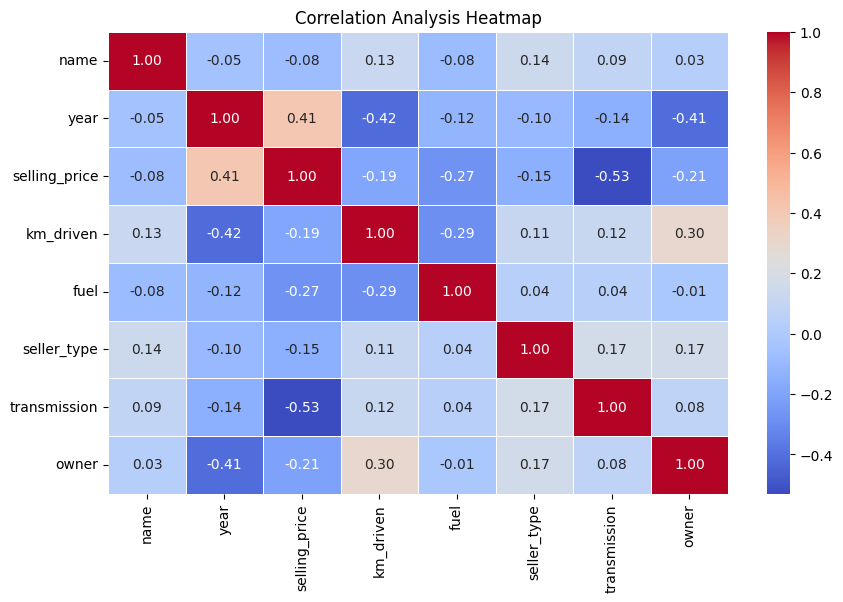

In [115]:
#first since we will be applying numeric transformations on these coloumns let us create a copy of our dataframe, so that our final dataframe remains untouched.

corr_car_df = car_df.copy()

label_encoders = {} #first we have to encode the labels in order to deal with non numeric values and still create a display to see our correlation.
for col in corr_car_df.select_dtypes(include=['object']).columns:
    label_encoders[col] = LabelEncoder()
    corr_car_df[col] = label_encoders[col].fit_transform(corr_car_df[col])

corr_matrix = corr_car_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Add a title
plt.title("Correlation Analysis Heatmap")

# Show the plot
plt.show()

Next we must look at the dataset. The data has eight coloumns: Name, Year, Selling Price, KM Driven, fuel, seller type, transmission, owner. Below I will summerize each of the coloumns and what logical transformations I will make to them in order to train a model that will have a high performance on the data.

Name: These names are unique strings; however, each string has the first word which is the brand of the car. We can use this first word, to one hot encode the cars into what brand they are. This can replace the name attribute.

 Year: This is an ordinal datapoint that is an integer, I will most likely keep these this way. I may make them smaller numbers by subtracting the minimum year found in the data

 Selling Price: This is the target value so we will not transform this.

 KM Driven: This is a useful ordinal integer, we will not transform this value.

 Fuel: This is a string which either takes the value Diesel, CNG, LNG Electric or Petrol. We will replace this with one hot encoding creating the new features: "is_petrol", "is_deisel", "is_electric", ect. these will take a 0 and 1 value depending on whether or not the car is petrol, electric, or diesel. This is done to create numeric values for this string, without imposing an ordinal structure that may or may not exist.

 Seller_type: This is a string that takes the value individual, Trustmark Dealer, or dealer. We will again one hot encode this feature
 
 Transmission: This is a string that takes the value manual or automatic, for this we will replace this feature with a single true of false "Automatic_transmission" attribute that takes a value of 0 or 1

 Owner: This is a string that says which owner it is, ie. "first owner" or "second owner", for this there is an ordinal component to this attribute, so we will simply replace this with an attribute "Owner_number" which has a numeric value of which owner this is. 

Underneath, we will conduct the above data processing steps.

First Let us Start with the Name Attribute. We are going to one hot encode this using the brands, these are each found at the beginning of the name string.

In [116]:
# Convert 'name' column to string before splitting and cleaning
car_df['brand'] = car_df["name"].str.split().str[0]

#Now Lets See which brands are in this dataframe.

print(car_df['brand'].unique())

car_df.head(5) # diplay the first 5 rows to show what we have done

['Maruti' 'Hyundai' 'Datsun' 'Honda' 'Tata' 'Chevrolet' 'Toyota' 'Jaguar'
 'Mercedes-Benz' 'Audi' 'Skoda' 'Jeep' 'BMW' 'Mahindra' 'Ford' 'Nissan'
 'Renault' 'Fiat' 'Volkswagen' 'Volvo' 'Mitsubishi' 'Land' 'Daewoo' 'MG'
 'Force' 'Isuzu' 'OpelCorsa' 'Ambassador' 'Kia']


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner,Maruti
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner,Maruti
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner,Hyundai
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner,Datsun
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner,Honda


In [117]:
# Drop the 'name' column
car_df.drop(columns='name', inplace=True)

# Apply one-hot encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')

ohetransform = ohe.fit_transform(car_df[['brand']])

car_df = pd.concat([car_df, ohetransform], axis = 1)
# Save the encoded DataFrame
car_df.head(7)


,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand,brand_Ambassador,brand_Audi,...,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_OpelCorsa,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012,600000,100000,Diesel,Individual,Manual,First Owner,Hyundai,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017,250000,46000,Petrol,Individual,Manual,First Owner,Datsun,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner,Honda,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2007,140000,125000,Petrol,Individual,Manual,First Owner,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2016,550000,25000,Petrol,Individual,Manual,First Owner,Hyundai,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we will address the Fuel attribute. This will be very similiar to the last as we will preform one hot encoding indicating whether the car is electric, CNG, diesel, LPG, or petrol.

In [118]:
ohe_fuel_transform = ohe.fit_transform(car_df[['fuel']])

car_df = pd.concat([car_df, ohe_fuel_transform], axis = 1)

car_df.head(7) #visualize that we did the process correctly

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand,brand_Ambassador,brand_Audi,...,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2012,600000,100000,Diesel,Individual,Manual,First Owner,Hyundai,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2017,250000,46000,Petrol,Individual,Manual,First Owner,Datsun,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner,Honda,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,2007,140000,125000,Petrol,Individual,Manual,First Owner,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,2016,550000,25000,Petrol,Individual,Manual,First Owner,Hyundai,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Now we have finished the Fuel attribute, so we will move onto the Seller_Type. Here we have three options, Ill generate a list of them below:

In [119]:
print(car_df['seller_type'].unique())

['Individual' 'Dealer' 'Trustmark Dealer']


So since these also do not have a clear ordinal component we will once again on hot encode.

In [120]:
ohe_seller_type_transform = ohe.fit_transform(car_df[['seller_type']])

car_df = pd.concat([car_df, ohe_seller_type_transform], axis = 1)

car_df.head(7) #visualize that we did the process correctly

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand,brand_Ambassador,brand_Audi,...,brand_Volkswagen,brand_Volvo,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2012,600000,100000,Diesel,Individual,Manual,First Owner,Hyundai,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2017,250000,46000,Petrol,Individual,Manual,First Owner,Datsun,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner,Honda,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,2007,140000,125000,Petrol,Individual,Manual,First Owner,Maruti,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,2016,550000,25000,Petrol,Individual,Manual,First Owner,Hyundai,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Next we will change the transmission attribute to a numeric 1 or 0 depending on whether or not the car is automatic. This will be easier for a model to interperate. 

In [121]:
car_df['is_automatic'] = np.where(car_df['transmission'] == 'automatic', 1, 0)

Finally we will transform the owner string into a number. First we will look at the different indicating strings by using the unique function, then we wil transform them.

In [122]:
print(car_df['owner'].unique())

['First Owner' 'Second Owner' 'Fourth & Above Owner' 'Third Owner'
 'Test Drive Car']


In [123]:
car_df['owner'] = car_df['owner'].map({
    'Test Drive Car': 0,
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4
})

Finally we will remove the now unused columns so that we have our final dataframe

In [124]:
car_df.drop(columns=['transmission', 'seller_type', 'fuel', 'brand'], inplace=True)

print(car_df.head(15))#display final datafame

car_df.to_csv('car_details_cleaned_data.csv', index=False) #print to a csv to use in any other projects we chose.

    year  selling_price  km_driven  owner  brand_Ambassador  brand_Audi  \
0   2007          60000      70000      1               0.0         0.0   
1   2007         135000      50000      1               0.0         0.0   
2   2012         600000     100000      1               0.0         0.0   
3   2017         250000      46000      1               0.0         0.0   
4   2014         450000     141000      2               0.0         0.0   
5   2007         140000     125000      1               0.0         0.0   
6   2016         550000      25000      1               0.0         0.0   
7   2014         240000      60000      2               0.0         0.0   
8   2015         850000      25000      1               0.0         0.0   
9   2017         365000      78000      1               0.0         0.0   
10  2015         260000      35000      1               0.0         0.0   
11  2014         250000     100000      1               0.0         0.0   
12  2018        1650000  

Now we have finished our data engineering and cleaning and we can move onto any modeling.